In [543]:

import nltk,re,time,umap,collections,os,string,sys,mlflow
sys.path.append(os.path.abspath(".."))
from modules import utils,modeling

from sentence_transformers import SentenceTransformer,util
import plotly.express as px
import pandas as pd
import glob
from sklearn.decomposition import PCA
from sklearn.metrics import completeness_score,homogeneity_score, v_measure_score,normalized_mutual_info_score,adjusted_mutual_info_score,silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from summa.summarizer import summarize
from summa.keywords import keywords
from hdbscan import HDBSCAN
from sentence_transformers import models
from sklearn.preprocessing import normalize
from torch import nn
import mlflow.sklearn
from  mlflow.tracking import MlflowClient
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_distances

import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from textwrap import wrap
stopwords = utils.load_stopwords()
from flexible_clustering import FISHDBC
import flexible_clustering
from collections import Counter
remote_server="http://18.196.243.158"
client = MlflowClient(remote_server)
mlflow.set_tracking_uri(remote_server)


%matplotlib inline
%load_ext autoreload
%autoreload 2

%reload_ext utils
%reload_ext modeling
os.environ["MLFLOW_S3_ENDPOINT_URL"]="http://s3.eu-central-1.amazonaws.com"
os.environ["MLFLOW_TRACKING_USERNAME"] = "mlflow"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "mlflow"

FISH = FISHDBC(cosine_distances)

Number of stopwords 607
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [462]:
# with mlflow.start_run():
#     client.log_param(key="lol",value="3")


In [544]:
X = utils.load_labeled_data()
X.drop(["site","entities_analyzed","updated_at"],inplace=True,axis="columns")

labeled = pd.read_csv("../data/raw_article_entities.csv",header=None,names=["_id","article_id",
                                                                            "kicker_headline_NER","text_NER",
                                                                            "seo_title_NER","created_at_ne",
                                                                            "updated_at","parset"])

labeled.drop(["parset","updated_at","_id"],axis=1,inplace=True)
labeled = labeled.set_index("article_id")

In [545]:
df = X[X.labels !=  44].copy() # REMOVE GOSSIP 
df['mix'] =  df['seo_title'].apply(lambda x: utils.remove_seo_title_marker(x,True)) +". "+ df["text"]
#pdf_mix = utils.preprocess_text(X,col="mix")
#pdf_mix = X["mix"].values
#print([ x for x in X["mix"].values if type(x) != str])
#X = X.join(labeled,how='inner')
#X.drop_duplicates(subset='headline',inplace=True)
pdf = utils.preprocess_articles_for_bert(df,"mix",lower=True)
pdf_ = utils.preprocess_articles_for_bert(df,"headline",lower=False)

y = df.labels
df.drop("labels",axis="columns",inplace=True)
df.tail(1)


,headline,text,seo_title,created_at_date,created_at,mix
article_uid,,,,,,
8ec404c985afbb5fab60b0f93ae8f0a52e7f0518c6ef55d6c3125e683a9493a4,Mega-Zoff auf „Love ISLAND“ - Penis-Protz Hend...,Gewitterwolken über der Liebesinsel! Der Sonnt...,Penis-Protz Hendrik geht auf Luca los,9/14/20,2020-09-14 02:19:15,. Gewitterwolken über der Liebesinsel! Der Son...


In [546]:
#wiki_embeddings = modeling.get_sentence_embeddings(pdf,SentenceTransformer("bert-base-wikipedia-sections-mean-tokens"),False)

embeddings = modeling.get_sentence_embeddings(pdf,models.Transformer( 'T-Systems-onsite/bert-german-dbmdz-uncased-sentence-stsb',max_seq_length=512),False)
headline_embeddings = modeling.get_sentence_embeddings(pdf_,models.Transformer( 'T-Systems-onsite/bert-german-dbmdz-uncased-sentence-stsb',max_seq_length=128),False)

#embeddings_v2 = modeling.get_sentence_embeddings(pdf_,models.Transformer( 'T-Systems-onsite/german-roberta-sentence-transformer-v2',max_seq_length=300),False)
#embeddings_v3 = modeling.get_sentence_embeddings(pdf_,models.Transformer( 'T-Systems-onsite/cross-en-de-roberta-sentence-transformer',max_seq_length=300),False)
#embeddings_300 = modeling.get_sentence_embeddings(pdf,models.Transformer( 'T-Systems-onsite/bert-german-dbmdz-uncased-sentence-stsb',max_seq_length=300),False)
#embeddings_400 = modeling.get_sentence_embeddings(pdf,models.Transformer( 'T-Systems-onsite/bert-german-dbmdz-uncased-sentence-stsb',max_seq_length=400),False)




--- Embedding dimension 768
--- 178 Documnets encoded 68.79832482337952 seconds ---



--- Embedding dimension 768
--- 178 Documnets encoded 4.085035085678101 seconds ---


In [202]:
os.path.basename("../models/bert-german-dbmdz-uncased-sentence-stsb/umap.jpg")

'umap.jpg'

AttributeError: 'AxesSubplot' object has no attribute 'show'

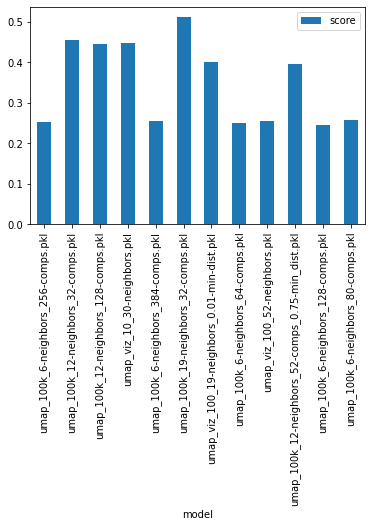

In [532]:
umaps = [(umap_model_path,modeling._preload_umap_reduce(embeddings,umap_model_path)) for umap_model_path in glob.glob("../models/*/umap*")]
res=[]
for (name,umap_data) in umaps:
    res.append((os.path.basename(name),silhouette_score(umap_data,y.values)))

pd.DataFrame(res,columns=['model','score']).set_index('model').plot(kind='bar')

In [452]:
glob.glob("../models/*/umap*")

['../models/bert-german-dbmdz-uncased-sentence-stsb/umap_100k_6-neighbors_256-comps.pkl',
 '../models/bert-german-dbmdz-uncased-sentence-stsb/umap_100k_12-neighbors_32-comps.pkl',
 '../models/bert-german-dbmdz-uncased-sentence-stsb/umap_100k_12-neighbors_128-comps.pkl',
 '../models/bert-german-dbmdz-uncased-sentence-stsb/umap_viz_10_30-neighbors.pkl',
 '../models/bert-german-dbmdz-uncased-sentence-stsb/umap_100k_6-neighbors_384-comps.pkl',
 '../models/bert-german-dbmdz-uncased-sentence-stsb/umap_100k_19-neighbors_32-comps.pkl',
 '../models/bert-german-dbmdz-uncased-sentence-stsb/umap_viz_100_19-neighbors_0.01-min-dist.pkl',
 '../models/bert-german-dbmdz-uncased-sentence-stsb/umap_100k_6-neighbors_64-comps.pkl',
 '../models/bert-german-dbmdz-uncased-sentence-stsb/umap_viz_100_52-neighbors.pkl',
 '../models/bert-german-dbmdz-uncased-sentence-stsb/umap_100k_12-neighbors_52-comps_0.75-min_dist.pkl',
 '../models/bert-german-dbmdz-uncased-sentence-stsb/umap_100k_6-neighbors_128-comps.pkl',
 

In [188]:
mlflow.set_experiment("FISHDBC Eval")

INFO: 'FISHDBC Eval' does not exist. Creating a new experiment


--- UMAP Loaded in 1.6217243671417236 seconds 
--- Reduced dimensionality to (178, 32) .
--- UMAP Loaded in 1.1036639213562012 seconds 
--- Reduced dimensionality to (178, 32) .
--- UMAP Loaded in 1.304570198059082 seconds 
--- Reduced dimensionality to (178, 2) .


In [193]:
y_summarized_clusters = dict(collections.Counter(y.values))

params={"min_samples":3,"ef":200}

efs= [2,3,4,5,6,7,8,9,10,300,350]
selection_methods= ['leaf','eom']
for ef in efs:
    for m0 in range(1,10,1):
        for m in range(2,15,1):
            for selection_method in selection_methods:
                params['ef']=ef
                params['m']=m
                params['m0']=m0
                with mlflow.start_run():
                    mlflow.log_params(params)

                    clusterer = flexible_clustering.FISHDBC(cosine_distances,**params)
                    for elem in umap_embeddings:
                        clusterer.add([elem])
                    clusterer.update_mst()
                    labels, probs, stabilities, condensed_tree, slt, mst = clusterer.cluster(cluster_selection_method=selection_method,min_cluster_size=3)
                    mlflow.log_param(key='cluster_selection_method',value=selection_methods)

                    
                    mlflow.log_metric(key="completeness_score", value=completeness_score(labels,y.values))
                    mlflow.log_metric(key="v_measure_score", value=v_measure_score(labels,y.values))
                    mlflow.log_metric(key="homogeneity_score", value=homogeneity_score(labels,y.values))
                    mlflow.log_metric(key="normalized_mutual_info_score", value=v_measure_score(labels,y.values))

                    summarized_clusters = dict(collections.Counter(labels))
                    try:
                        mlflow.log_metric(key="outliers_ratio", value=(summarized_clusters[-1]/len(labels)))
                    except Exception as err:
                        mlflow.log_metric(key="outliers_ratio", value=0)

                    mlflow.log_metric(key="unique_cluters", value=len(summarized_clusters.items()))
                    mlflow.log_metric(key="clusters_ratio_to_GT", value=(len(summarized_clusters.items())-1)/len(y_summarized_clusters.items()))
                    mlflow.log_metric(key="silhuette_score", value=silhouette_score(embeddings,labels))
                    mlflow.log_metric(key="silhuette_score_true", value=silhouette_score(embeddings,y.values))
                    results = utils.link_to_raw_data(viz,df,labels)

                    try:
                        pass
                        #modeling.scatter_plot(results,save_fig=True)
                        #mlflow.log_artifact("./tmp_scatter_plot.html")
                    except Exception as err:
                        print(err)
                    print("Done!")
                    

In [547]:
umap_embeddings = modeling._preload_umap_reduce(embeddings,model='bert-german-dbmdz-uncased-sentence-stsb/umap_100k_19-neighbors_32-comps.pkl')
viz = modeling.load_umap_viz_and_reduce(embeddings)

#Trying out mean of two embeddings = no big diffrence 
headline_umap_embeddings = modeling._preload_umap_reduce(headline_embeddings,model='bert-german-dbmdz-uncased-sentence-stsb/umap_100k_19-neighbors_32-comps.pkl')
emb=np.array([np.mean( np.array([ a, b ]), axis=0 ) for (a,b) in zip(umap_embeddings,headline_umap_embeddings)])


silhouette_score(umap_embeddings,y.values),silhouette_score(headline_umap_embeddings,y.values),silhouette_score(emb,y.values)

--- UMAP Loaded in 3.1726720333099365 seconds 
--- Reduced dimensionality to (178, 32) .
--- UMAP Loaded in 2.142125129699707 seconds 
--- Reduced dimensionality to (178, 2) .
--- UMAP Loaded in 4.9649739265441895 seconds 
--- Reduced dimensionality to (178, 32) .


(0.5115531, 0.17381635, 0.3655683)

# Animaotion


In [542]:



from ipywidgets import interact


@interact(m=(1,10,1), ef=(1,10,1))
def test(m=6,ef=1):
    params={"min_samples":3,"ef":ef,'m0':None, "m":m}
    clusterer = flexible_clustering.FISHDBC(cosine_distances,**params)
    for elem in emb:
        clusterer.add([elem])
    clusterer.update_mst()
    clusters = collections.defaultdict(set)
    labels, probs, stabilities, condensed_tree, slt, mst = clusterer.cluster(cluster_selection_method="leaf",min_cluster_size=3)
    for parent, child, lambda_val, child_size in condensed_tree[::-1]:
        if child_size == 1:
            clusters[parent].add(child)
        else:
            assert len(clusters[child]) == child_size
            clusters[parent].update(clusters[child])
        
#    print("Cluster count: {} \n Outliers: {}({})".format(len(set(labels)),dict(Counter(labels))[-1],dict(Counter(labels))[-1]/len(labels) ))
    pd.DataFrame(dict(Counter(labels)).items(),columns=['label','count']).sort_values("count").set_index("label").plot(kind="bar")
    print("silhouette_score true: {}".format(silhouette_score(embeddings,labels)))
    print("silhouette_score pred: {}".format(silhouette_score(embeddings,Y)))
    print("v_measure_score: {}".format(v_measure_score(labels,Y)))
    modeling.scatter_plot(utils.relink_data_after_clustering(viz,df,labels),opacity=probs)
    tree = pd.DataFrame(condensed_tree).sort_values(by='child_size',ascending=False)
    tree.parent = tree.parent.apply(str)
    tree.child = tree.child.apply(str)
    fig =px.treemap(
    tree[tree.child_size > 3],
    names='child',
    parents='parent',
    values='child_size',
    )
    fig.show()

interactive(children=(IntSlider(value=6, description='m', max=10, min=1), IntSlider(value=1, description='ef',…

In [428]:


fig =px.treemap(
    tree[tree.child_size > 3],
    names='child',
    parents='parent',
    values='child_size',
)
fig.show()

'black'

In [540]:
import sklearn as sk
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex


data = umap_embeddings
labels = Y.values
#np.random.shuffle(data)

x, y = viz[:,0],viz[:,1]


def cos_sim(a, b):
    dot_product = np.inner(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return 1- (dot_product / (norm_a * norm_b))

params={"min_samples":3,"ef":1,'m0':None, "m":6}
#clusterer = flexible_clustering.FISHDBC(cosine_distances,**params)
    
fishdbc = FISHDBC(cos_sim,**params)

#plt.figure(figsize=(9, 9))
#plt.gca().set_aspect('equal')
frames = []
for points in np.array_split(data, 20):
    fishdbc.update(points)
    fishdbc.update_mst()
    nknown = len(fishdbc.data)
    tmp_labels, proba, _, ctree, _, _ = fishdbc.cluster(cluster_selection_method="eom",min_cluster_size=3)
    clusters = collections.defaultdict(set)
    
#     for parent, child, lambda_val, child_size in ctree[::-1]:
#         if child_size == 1:
#             clusters[parent].add(child)
#         else:
#             assert len(clusters[child]) == child_size
#             clusters[parent].update(clusters[child])
    clusters = sorted(clusters.items())
    xknown, yknown, labels_known = x[:nknown], y[:nknown], tmp_labels[:nknown]
    #color = ['rgbcmyk'[l % 7] for l in labels_known]
    #print(list(zip(zip(xknown, yknown),labels)))

    
    frames.append(go.Frame(data=[go.Scatter(x=xknown,text=tmp_labels,hovertext=["({}). {}".format(a,b) for (a,b) in zip(tmp_labels,df.headline.values)], 
                                            y=yknown,mode='markers',#marker_color=[colors_dict[x] for x in tmp_labels],
                                               marker = {
                                                         "color":tmp_labels,#list(map(lambda x:rgb2hex(m.to_rgba(x)),tmp_labels)),
                                                            "showscale":True,
                                                   "autocolorscale":True,
                                                   "size": 10,
                                                                                                   #"colorscale":px.colors.sequential.Plasma, # one of plotly colorscales
                                               # "cmin":-1,
                                                #    "cmid":0,
                                                #   "cmax":20,
                                               #"name": tmp_labels,
                                           # "cauto":False
                                                         }) 
                                            ]))
print("v_measure_score: {}".format(v_measure_score(tmp_labels,Y)))

v_measure_score: 0.8471475221757367


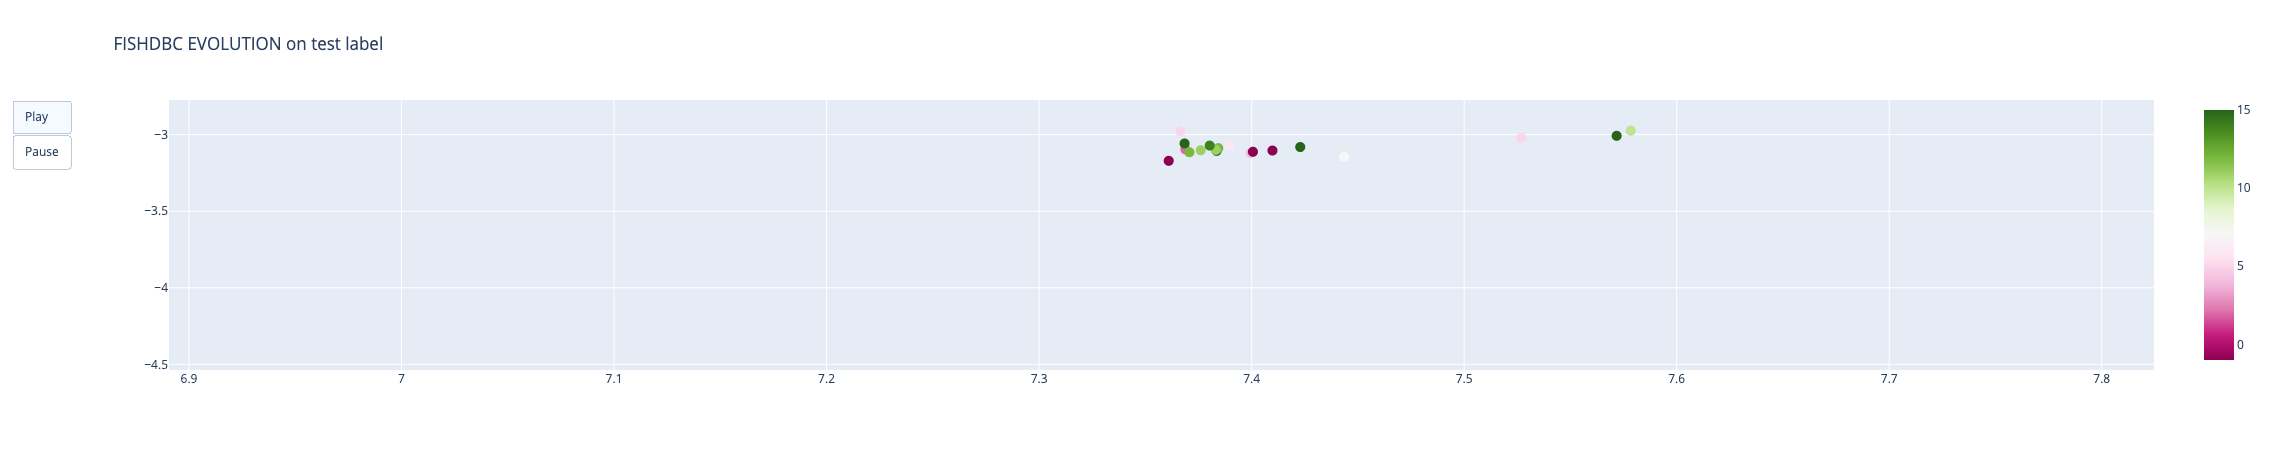

In [523]:
# import plotly.graph_objects as go

fig = go.Figure(
    
    data=[frames[0].data[0]],
    layout=go.Layout(
        xaxis=dict(range=[2,16] ,autorange=False),
        yaxis=dict(range=[-6,8] ,autorange=False),
        title="FISHDBC EVOLUTION on test label",
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None,{
        "mode": 'immediate',"fromcurrent": True,
        "transition": {"duration": 300}}]),
            {
                "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                  "mode": "immediate",
                                  "transition": {"duration": 0}}],
                "label": "Pause",
                "method": "animate"
            }
                    
                    
                    ])]
    ),
    frames=frames[1:]

)

fig.show()

In [509]:
s=[[1, 2], [3, 4], [5, 6], [7, 8], [3, 4], [5, 6]]
np.random.shuffle(s)
s

[[5, 6], [1, 2], [5, 6], [3, 4], [3, 4], [7, 8]]

In [483]:
from sklearn.model_selection import ShuffleSplit
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [3, 4], [5, 6]])
y = np.array([1, 2, 1, 2, 1, 2])
rs = ShuffleSplit(n_splits=5,  random_state=0)
rs

for train_index, test_index in rs.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [2 1 3 0 4] TEST: [5]
TRAIN: [3 4 0 2 5] TEST: [1]
TRAIN: [5 1 2 4 0] TEST: [3]
TRAIN: [2 3 4 1 0] TEST: [5]
TRAIN: [4 3 5 1 0] TEST: [2]


In [548]:
from modules import DenStream

In [549]:
cl = DenStream()


TypeError: 'module' object is not callable